In [1]:
# import libraries
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf
import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from fbprophet import Prophet
import warnings
import requests
import bs4 as bs
from bs4 import BeautifulSoup
import random
warnings.filterwarnings('ignore')

KeyboardInterrupt: 

# 1. ARIMA (AutoRegressive Integrated Moving Average)

In [2]:
class ARIMA_model():
    def __init__(self, symbol, start, end=datetime.datetime.today()):
        self.symbol = symbol
        self.start = start
        self.end = end

    def get_data(self, auto_regressive_order, moving_avg_order, differencing_order, RSI_S, RSI_L):
        
        self.auto_regressive_order = auto_regressive_order
        self.moving_avg_order = moving_avg_order
        self.differencing_order = differencing_order
        self.RSI_S = RSI_S
        self.RSI_L = RSI_L

        # download data
        data = yf.download(self.symbol, start=self.start, end=self.end).loc[:, "Close"].to_frame()
        
        # split data into train and test
        training_data = data[:int(len(data) * 0.8)]
        test_data = data[int(len(data) * 0.8):]

        # create ARIMA model
        model = ARIMA(training_data, order=(self.auto_regressive_order, self.differencing_order, self.moving_avg_order))
        model_fit = model.fit()

        # get predictions
        predictions = model_fit.predict(start=len(training_data), end=len(training_data) + len(test_data) - 1, typ="levels").to_frame()
        
        # create technical indicators
        # short term RSI
        predictions.ta.rsi(length=self.RSI_S, append=True, append_to_df=True)
        
        # long term RSI
        predictions.ta.rsi(length=self.RSI_L, append=True, append_to_df=True)
        
        # create buy and sell signals
        predictions["RSI_S_greater_than_RSI_L"] = np.where(predictions[f"RSI_{self.RSI_S}"] > predictions[f"RSI_{self.RSI_L}"], True, False)
        predictions["RSI_S_less_than_RSI_L"] = np.where(predictions[f"RSI_{self.RSI_S}"] < predictions[f"RSI_{self.RSI_L}"], True, False)
        
        # Crossover
        predictions["RSI_S_greater_than_RSI_L_CO"] = np.where(
            predictions["RSI_S_greater_than_RSI_L"] == False, False,
            predictions["RSI_S_greater_than_RSI_L"].ne(predictions["RSI_S_greater_than_RSI_L"].shift())
            )
        
        predictions["RSI_S_less_than_RSI_L_CO"] = np.where(
            predictions["RSI_S_less_than_RSI_L"] == False, False,
            predictions["RSI_S_less_than_RSI_L"].ne(predictions["RSI_S_less_than_RSI_L"].shift())
            )
        
        # Buy and Sell signals
        buysignals = predictions[predictions["RSI_S_greater_than_RSI_L_CO"] == True]
        sellsignals = predictions[predictions["RSI_S_less_than_RSI_L_CO"] == True]

        # position
        predictions["position"] = np.where(predictions[f"RSI_{self.RSI_S}"] > predictions[f"RSI_{self.RSI_L}"], 1, 0)
                
        # buy_and_hold
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))

        # strategy
        data["strategy"] = data["position"].shift(1) * data["buy_and_hold"]

        # drop na
        data.dropna(inplace=True)

        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals

        return data, buysignals, sellsignals

    
    def performance_summary(self):
        
        # calculate sum of buy_and_hold
        # calculate sum
        print("Sum of returns:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} Mean Reversion with RSI of {self.mr_period} days")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot buy and sell signals
        self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
        plt.title(f"Buy and Sell signals of {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        plt.scatter(self.buysignals.index, self.buysignals["Close"], marker="^", color="green")
        plt.scatter(self.sellsignals.index, self.sellsignals["Close"], marker="v", color="red")               

        plt.legend()
        plt.show()

# Optimizing ARIMA model

In [64]:
data = yf.download("AAPL", start="2010-01-01", end="2023-06-01").loc[:, "Close"].to_frame()

# use adfuller to check if the data is stationary
def adf_test(series):
    
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    
    print("=" * 50)
    if result[1] > 0.05: # P-value
        print("The data is not stationary.")
    else:
        print("The data is stationary.")
    print("=" * 50)
    
# original data
adf_test(data["Close"])

# take the difference to remove trend, seasonality and noise
data["adf_diff"] = data["Close"] - data["Close"].shift(1)

# perform test on the differenced data
adf_test(data["adf_diff"].dropna())

[*********************100%***********************]  1 of 1 completed
ADF Statistic: 0.8133478795973875
p-value: 0.9918486010171178
Critical Values:
	1%: -3.4323023612249797
	5%: -2.8624026392273474
	10%: -2.5672291998828043
The data is not stationary.
ADF Statistic: -12.051141955502157
p-value: 2.595743573822828e-22
Critical Values:
	1%: -3.4323023612249797
	5%: -2.8624026392273474
	10%: -2.5672291998828043
The data is stationary.


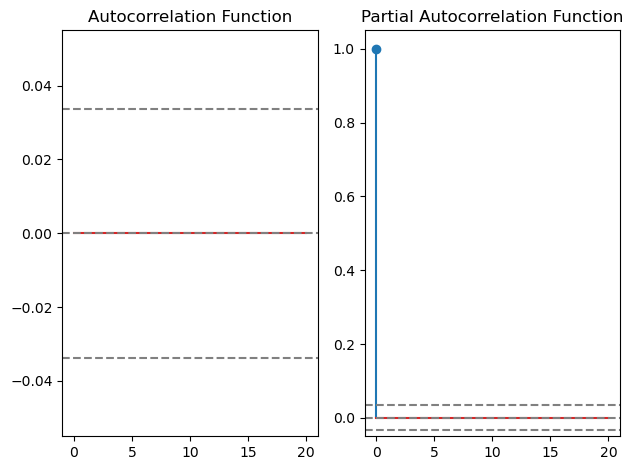

Best ARIMA order: (1, 0, 1)


In [65]:
# Calculate the ACF and PACF
lag_acf = acf(data['adf_diff'], nlags=20)
lag_pacf = pacf(data['adf_diff'], nlags=20, method='yw')

# Plot ACF
plt.subplot(121)
plt.stem(range(len(lag_acf)), lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data['adf_diff'])), linestyle='--', color='gray') # 95% confidence interval
plt.axhline(y=1.96/np.sqrt(len(data['adf_diff'])), linestyle='--', color='gray') # 95% confidence interval
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.stem(range(len(lag_pacf)), lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data['adf_diff'])), linestyle='--', color='gray') # 95% confidence interval
plt.axhline(y=1.96/np.sqrt(len(data['adf_diff'])), linestyle='--', color='gray') # 95% confidence interval
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

def evaluate_arima_model(order):
    model = ARIMA(data['adf_diff'], order=order)
    try:
        model_fit = model.fit()
        return model_fit.aic
    except:
        return np.inf

# Define the range of values to search for p, q, and d
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

# Perform grid search to find the optimal combination of p, q, and d
best_aic = np.inf
best_order = None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                aic = evaluate_arima_model(order)
                if aic < best_aic:
                    best_aic = aic
                    best_order = order
            except:
                continue

print("Best ARIMA order:", best_order)

ARIMA model can predict the future values of a time series by analyzing the patterns in the past values. <br>
However, it requires alot of configuration to get the best out of the model. <br>
Furthermore, as the stock application searches the S&P 500 stocks, it is not possible to optimize the model for each stock. <br>

# Notebook test

[*********************100%***********************]  1 of 1 completed
Sum of returns:
buy_and_hold    1.356886
strategy        1.185301
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold  strategy
Date                              
2019-06-06      1.014682  1.000000
2019-06-07      1.041689  1.026617
2019-06-10      1.055002  1.039737
2019-06-11      1.067218  1.051776
2019-06-12      1.063822  1.048429
...                  ...       ...
2023-05-24      3.765531  3.238078
2023-05-25      3.790731  3.238078
2023-05-26      3.844199  3.238078
2023-05-30      3.885176  3.272594
2023-05-31      3.884080  3.271672

[1004 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2019-06-06
End date,2023-05-31
Total months,47
,Backtest
Annual return,31.8%
Cumulative returns,200.8%
Annual volatility,20.5%
Sharpe ratio,1.45
Calmar ratio,1.75
Stability,0.93
Max drawdown,-18.2%


##################################################


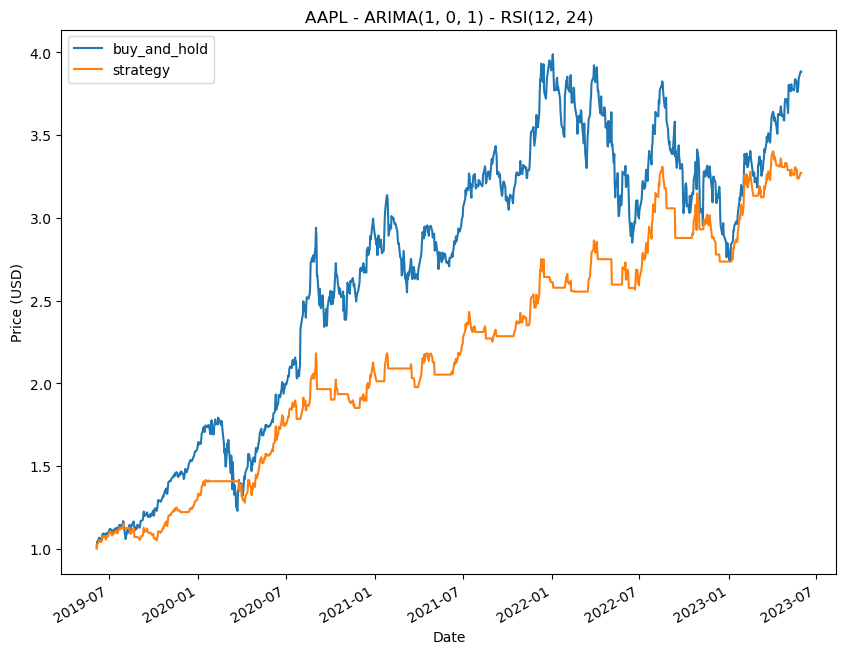

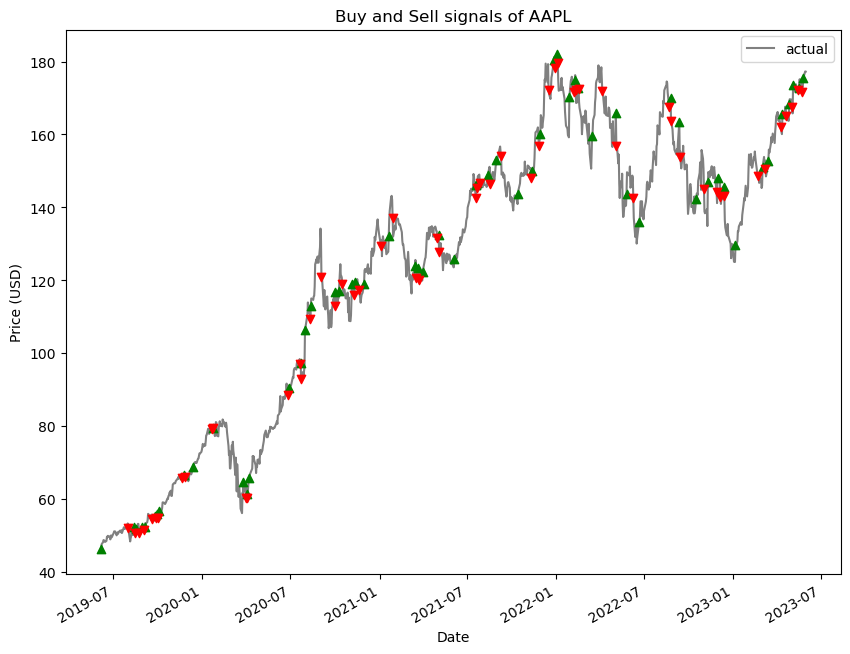

In [12]:
symbol = "AAPL"
start = "2003-01-01"
end = "2023-06-01"

data = yf.download(symbol, start=start, end=end).loc[:, "Close"].to_frame()

# convert to stationary
data["adf_diff"] = data["Close"] - data["Close"].shift(1)

# split data into train and test
training_data = data[:int(len(data) * 0.8)]
test_data = data[int(len(data) * 0.8):]

# create ARIMA model
model = ARIMA(training_data["adf_diff"], order=(1, 0, 1))
model_fit = model.fit()

# get predictions
predictions = model_fit.predict(start=len(training_data), end=len(training_data) + len(test_data) -1, typ="original").to_frame()

# set the index of predictions_df to be the dates in test_data
predictions.set_index(test_data.index, inplace=True)

# append predictions to test_data
predictions["actual"] = test_data["Close"]

# create technical indicators
RSI_S = 12
RSI_L = 24

# short term RSI
predictions.ta.rsi(length=RSI_S, close = predictions["actual"], append=True, append_to_df=True)

# # long term RSI
predictions.ta.rsi(length=RSI_L, close = predictions["actual"], append=True, append_to_df=True)

# create buy and sell signals
predictions["RSI_S_greater_than_RSI_L"] = np.where(predictions[f"RSI_{RSI_S}"] > predictions[f"RSI_{RSI_L}"], True, False)
predictions["RSI_S_less_than_RSI_L"] = np.where(predictions[f"RSI_{RSI_S}"] < predictions[f"RSI_{RSI_L}"], True, False)

# Crossover
predictions["RSI_S_greater_than_RSI_L_CO"] = np.where(
     predictions["RSI_S_greater_than_RSI_L"] == False, False,
     predictions["RSI_S_greater_than_RSI_L"].ne(predictions["RSI_S_greater_than_RSI_L"].shift())
     )

predictions["RSI_S_less_than_RSI_L_CO"] = np.where(
     predictions["RSI_S_less_than_RSI_L"] == False, False,
     predictions["RSI_S_less_than_RSI_L"].ne(predictions["RSI_S_less_than_RSI_L"].shift())
     )

# position
predictions["position"] = np.where(predictions[f"RSI_{RSI_S}"] > predictions[f"RSI_{RSI_L}"], 1, 0)

# buy and hold
predictions["buy_and_hold"] = np.log(predictions["actual"] / predictions["actual"].shift(1))

# strategy
predictions["strategy"] = predictions["position"].shift(1) * predictions["buy_and_hold"]

# drop NA
predictions.dropna(inplace=True)

# set date as index
predictions.reset_index(inplace=True)
predictions.set_index('Date', inplace=True)

# generate buy and sell signals
buysignals = predictions[predictions["RSI_S_greater_than_RSI_L_CO"] == True]
sellsignals = predictions[predictions["RSI_S_less_than_RSI_L_CO"] == True]

print("Sum of returns:")
print(predictions[["buy_and_hold", "strategy"]].sum(), "\n")
print("#" * 50)

# calculate what $1 would be worth
print("What $1 would be worth:")
print(predictions[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
print("#" * 50)

# performance summary
print("Performance metrics:")
pf.show_perf_stats(predictions["strategy"])
print("#" * 50)

# plot the strategy vs buy and hold
# Plot graph
predictions[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
plt.legend(loc="upper left")
plt.title(f"{symbol} - ARIMA(1, 0, 1) - RSI({RSI_S}, {RSI_L})")
plt.ylabel("Price (USD)")
plt.xlabel("Date")

# Plot buy and sell signals
predictions[["actual"]].plot(figsize=(10, 8), color="gray", zorder=1)
plt.title(f"Buy and Sell signals of {symbol}")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.scatter(buysignals.index, buysignals["actual"], marker="^", color="green", zorder=2)
plt.scatter(sellsignals.index, sellsignals["actual"], marker="v", color="red", zorder=2)
plt.legend()
plt.show()

# 2. ETS (Error, Trend, Seasonality)

In [17]:
symbol = "TSLA"
start = "2017-01-01"
end = "2022-07-01"

# download the data
data = yf.download(symbol, start=start, end=end).loc[:, "Close"]

# Split the data into train and test
training_data = data[:int(len(data) * 0.8)]
test_data = data[int(len(data) * 0.8):]

# initialize the model
ets_model = ETSModel(training_data, trend = "add", seasonal="add", seasonal_periods=12)
ets_fit = ets_model.fit()

# get predictions
predictions = ets_fit.forecast(steps=len(test_data))

# Plot the data

plt.figure(figsize=(10, 6))
plt.plot(training_data.index, training_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(test_data.index, predictions, label='Predicted Test Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f' {symbol} Stock Price Prediction using ETS Model')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


ETS is generally not suitable for a stock price application the app scans through all the S&P 500 stocks. <br>
As each stock has a different trend, seasonality, and error, it is not possible to use ETS for all the stocks. <br>
Furthermore, ETS generally shows the trend, hence it's difficult to plot actual buy/sell signals. <br>


# 3. Prophet Model